In [2]:
import numpy as np
import astra
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import scipy as sp
import pywt
from scipy.sparse import linalg
from scipy.linalg import solve
from scipy.sparse import csc_matrix
from skimage.restoration import denoise_tv_chambolle
%matplotlib inline

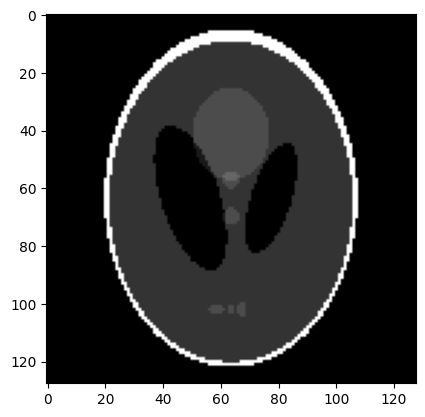

In [6]:
f = np.load("SLphan.npy")
plt.imshow(f, cmap='gray')

In [573]:
det = 200
# Create volume geometries
v,h = f.shape
vol_geom = astra.create_vol_geom(v,h)

# Create projector geometries
angles = np.linspace(0,np.pi,180,endpoint=False)
proj_geom = astra.create_proj_geom("parallel",1.,det,angles)

# Create projector
projector_id = astra.create_projector("strip", proj_geom, vol_geom)

# Radon transform (generate sinogram)
sinogram_id, sinogram = astra.create_sino(f, projector_id)

In [856]:
def under_sample(f, num_samples, skips,skip_size):
    v, h = f.shape
    num_pixels = h // num_samples

    sampled_f = np.zeros(f.shape)
    mask = np.ones(f.shape)

    # skip every other slice
    counter = 0
    skip_counter = 0
    for i in range(0, num_samples):
        if (counter <= skips):
            sampled_f[num_pixels*i:num_pixels*(i+1), :] = f[num_pixels*i:num_pixels*(i+1),:]
            mask[num_pixels*i:num_pixels*(i+1), :] = 0
            counter += 1
        else:
            skip_counter += 1
            if (skip_counter > skip_size):
                counter = 0
                skip_counter = 0
    sampled_f[-1, :] = f[-1, :]

    mask[0, :] = 0
    mask[-1, :] = 0
    mask[:, 0] = 0
    mask[:, -1] = 0

    return sampled_f, mask

In [801]:
def limited_angle(f, start, end):
    limited_angle_f = np.zeros(f.shape)
    mask = np.ones(f.shape)
    limited_angle_f[0:start, :] = f[0:start, :]
    limited_angle_f[end:, :] = f[end:, :]
    mask[0:start, :] = 0
    mask[end:, :] = 0
    mask[0, :] = 0
    mask[-1, :] = 0
    mask[:, 0] = 0
    mask[:, -1] = 0

    return limited_angle_f, mask


Text(0.5, 1.0, 'Limited Angles')

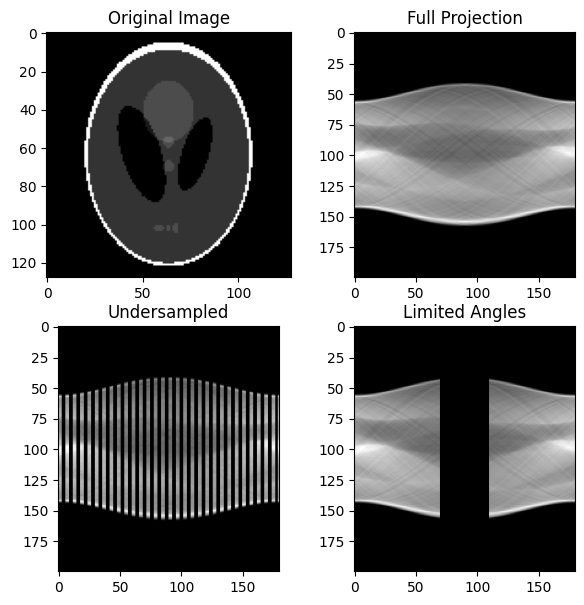

In [857]:
under_sampled_sino, us_mask = under_sample(sinogram, 180, 2, 2)
limited_angles_sino, la_mask = limited_angle(sinogram, 70, 110)

fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(f, cmap='gray')
plt.gca().set_title('Original Image')

ax2 = fig.add_subplot(2,2,2)
ax2.imshow(sinogram.T, cmap='gray')
plt.gca().set_title('Full Projection')

ax3 = fig.add_subplot(2,2,3)
ax3.imshow(under_sampled_sino.T, cmap='gray')
plt.gca().set_title('Undersampled')

ax4 = fig.add_subplot(2,2,4)
ax4.imshow(limited_angles_sino.T, cmap='gray')
plt.gca().set_title('Limited Angles')


In [865]:
def inpaint(img, mask):
    w, h = img.shape
    region = []
    boundary = []

    for i in range(1, w-1):
        for j in range(1, h-1):
            # four connecting neighbors of the current pixel
            n = [[i-1, j], [i+1, j], [i, j-1], [i, j+1]]

            # if pixel is inside region, i.e. known
            if mask[i, j] == 1:
                # record index to list of points inside region
                region.append([i, j])

                # check each neighbor of the current pixel
                for neighbor in n:
                    # if neighbor not in region, mark it as a boundary pixel
                    if mask[neighbor[0], neighbor[1]] == 0:
                        boundary.append([neighbor[0], neighbor[1]])

    # creates a correspondence between region pixels in a 1d vector and region pixels in the img coords
    region_map = np.ones(img.shape).astype(int)
    # initialize all values to -1, if -1, then pixel not in region
    region_map = -region_map
    for idx in range(len(region)):
        i, j = region[idx]
        # image coords as key, index in 1d vector as values
        region_map[i, j] = idx

    # creates a correspondence between boundary pixels in a 1d vector and region pixels in the img coords
    boundary_map = np.ones(img.shape).astype(int)
    # initialize all values to -1, if -1, then pixel not on boundary
    boundary_map = -boundary_map
    for idx in range(len(boundary)):
        i, j = boundary[idx]
        # image coords as key, index in 1d vector as values
        boundary_map[i, j] = idx

    region = np.array(region)
    length = region.shape[0]
    A = np.zeros([length,length])
    b = np.zeros([length, 1])

    for idx in range(length):
        i, j = region[idx]
        # setting diagonals of the A matrix 
        A[idx, idx] = 4

        # four connecting neighbors of the current pixel
        neighbors = [[i, j-1], [i, j+1], [i-1, j], [i+1, j]]

        for neighbor in neighbors:
            n_i, n_j = neighbor
            # find the neighbor pixel's index in the 1d vector for region pixels
            region_idx = region_map[n_i, n_j]
            # if neighbor pixel is inside the region
            if region_idx > -1:
                # fill in the rows of the A matrix
                A[idx, region_idx] = -1

            boundary_idx = boundary_map[n_i, n_j]
            if boundary_idx > -1:
                b[idx] = b[idx] + img[n_i, n_j]
                
    a = csc_matrix(A)
    x = linalg.spsolve(a, b)

    new_img = img.copy()
    counter = 0
    for pxl in region:
        i, j = pxl
        new_img[i, j] = x[counter]
        counter += 1

    return new_img

In [869]:
us_painted = inpaint(under_sampled_sino, us_mask)
la_painted = inpaint(limited_angles_sino, la_mask)

Text(0.5, 1.0, 'Limited Angles Painted')

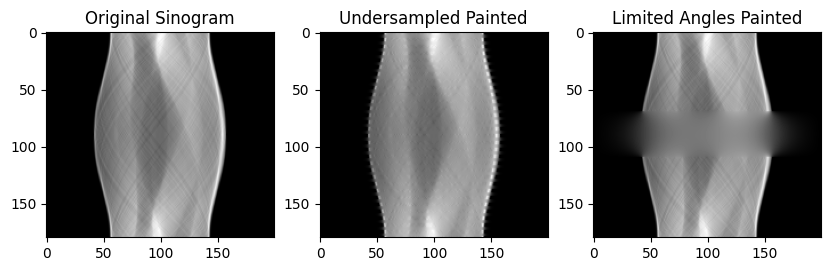

In [871]:
fig = plt.figure(figsize=(10, 5))
ax0 = fig.add_subplot(1,3,1)
ax0.imshow(sinogram, cmap='gray')
plt.gca().set_title('Original Sinogram')
ax1 = fig.add_subplot(1,3,2)
ax1.imshow(us_painted, cmap='gray')
plt.gca().set_title('Undersampled Painted')
ax2 = fig.add_subplot(1,3,3)
ax2.imshow(la_painted, cmap='gray')
plt.gca().set_title('Limited Angles Painted')

In [873]:
def back_proj(img, proj_geom, vol_geom, projector_id):
    new_id = astra.data2d.create("-sino", proj_geom, img)

    # Create a data object for the reconstruction
    rec_id = astra.data2d.create("-vol", vol_geom)

    # Set up the parameters for a reconstruction via back-projection
    cfg = astra.astra_dict("FBP")
    cfg["ReconstructionDataId"] = rec_id
    cfg["ProjectionDataId"] = new_id
    cfg["ProjectorId"] = projector_id

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    # Run back-projection and get the reconstruction
    astra.algorithm.run(alg_id)
    f_rec = astra.data2d.get(rec_id)

    return f_rec

Text(0.5, 1.0, 'Limited Angles Reconstruction')

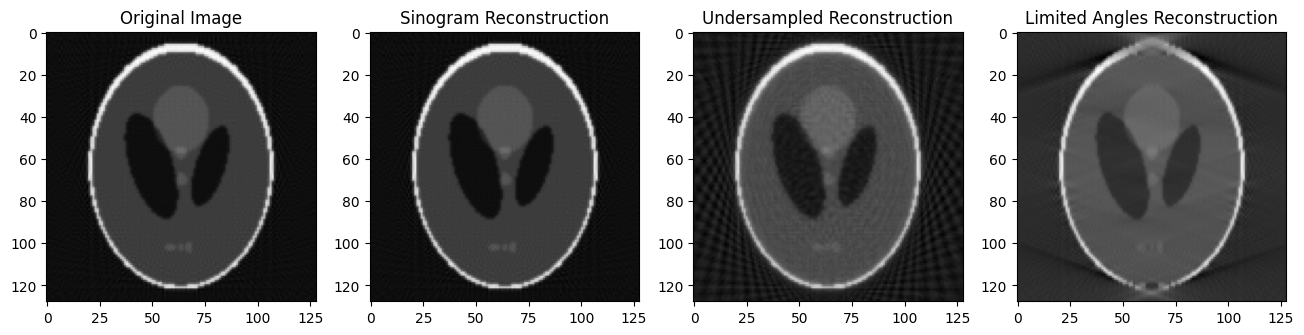

In [897]:
g_og = back_proj(sinogram, proj_geom, vol_geom, projector_id)
g_us = back_proj(us_painted, proj_geom, vol_geom, projector_id)
g_la = back_proj(la_painted, proj_geom, vol_geom, projector_id)

fig = plt.figure(figsize=(16, 5))
ax4 = fig.add_subplot(1,4,1)
ax4.imshow(g_og, cmap='gray')
plt.gca().set_title('Original Image')
ax0 = fig.add_subplot(1,4,2)
ax0.imshow(g_og, cmap='gray')
plt.gca().set_title('Sinogram Reconstruction')
ax1 = fig.add_subplot(1,4,3)
ax1.imshow(g_us, cmap='gray')
plt.gca().set_title('Undersampled Reconstruction')
ax2 = fig.add_subplot(1,4,4)
ax2.imshow(g_la, cmap='gray')
plt.gca().set_title('Limited Angles Reconstruction')

Text(0.5, 1.0, 'Limited Angles Wavelet De-noised')

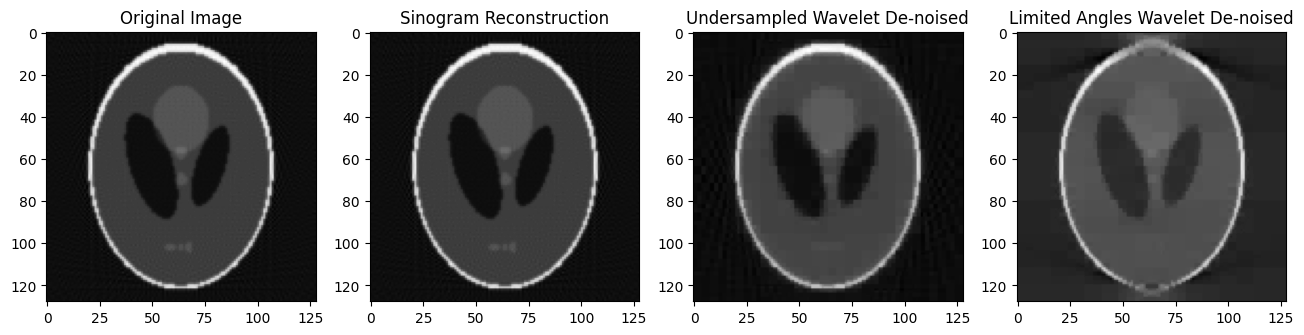

In [888]:
g_us_denoise, L2 = wavelet_denoise(g_us, 7, 0.05)
g_la_denoise, L2 = wavelet_denoise(g_la, 7, 0.05)
fig = plt.figure(figsize=(16, 5))
ax4 = fig.add_subplot(1,4,1)
ax4.imshow(g_og, cmap='gray')
plt.gca().set_title('Original Image')
ax0 = fig.add_subplot(1,4,2)
ax0.imshow(g_og, cmap='gray')
plt.gca().set_title('Sinogram Reconstruction')
ax1 = fig.add_subplot(1,4,3)
ax1.imshow(g_us_denoise, cmap='gray')
plt.gca().set_title('Undersampled Wavelet De-noised')
ax2 = fig.add_subplot(1,4,4)
ax2.imshow(g_la_denoise, cmap='gray')
plt.gca().set_title('Limited Angles Wavelet De-noised')

Text(0.5, 1.0, 'Limited Angles TV De-noised')

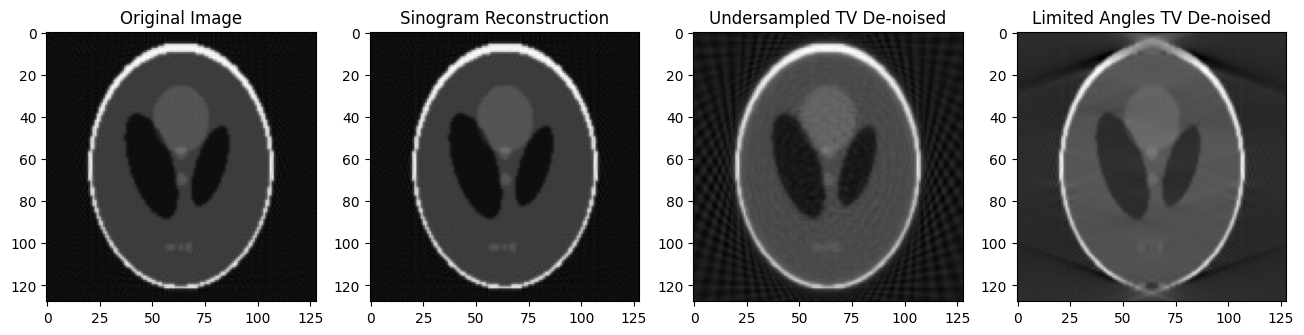

In [896]:
us_painted_denoised = denoise_tv_chambolle(us_painted, weight=0.3, channel_axis=-1)
g_us_denoised = back_proj(us_painted_denoised, proj_geom, vol_geom, projector_id)

la_painted_denoised = denoise_tv_chambolle(la_painted, weight=0.3, channel_axis=-1)
g_la_denoised = back_proj(la_painted_denoised, proj_geom, vol_geom, projector_id)

fig = plt.figure(figsize=(16, 5))
ax4 = fig.add_subplot(1,4,1)
ax4.imshow(g_og, cmap='gray')
plt.gca().set_title('Original Image')
ax0 = fig.add_subplot(1,4,2)
ax0.imshow(g_og, cmap='gray')
plt.gca().set_title('Sinogram Reconstruction')
ax1 = fig.add_subplot(1,4,3)
ax1.imshow(g_us_denoised, cmap='gray')
plt.gca().set_title('Undersampled TV De-noised')
ax2 = fig.add_subplot(1,4,4)
ax2.imshow(g_la_denoised, cmap='gray')
plt.gca().set_title('Limited Angles TV De-noised')